# Solution to Task 10.1

In [1]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cf_units
iris.FUTURE.date_microseconds = True

In [2]:
# change to your suite-id to pick up the required file
runid='du516'
# this is the grid we want to regrid to, e.g. N48 ENDGame
datafile='/home/vagrant/cylc-run/u-'+runid+'/runN/work/1/atmos/atmosa.pa19810901_00'

Remember to change the file containing the source data:

In [3]:
# read-in raw emissions data
emiss=iris.load_cube('/home/vagrant/Tutorials/UMvn13.9/data/Task10.1/Emissions_of_ALICE.nc')
# make intersection between 0 and 360 longitude to ensure that 
# the data is regridded correctly
nemiss = emiss.intersection(longitude=(0, 360))

/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/loading.py:582: IrisLoadWarning: Not all file objects were parsed correctly. See iris.loading.LOAD_PROBLEMS for details.
  warnings.warn(message, category=IrisLoadWarning)


/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/coords.py:1980: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/coords.py:1980: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


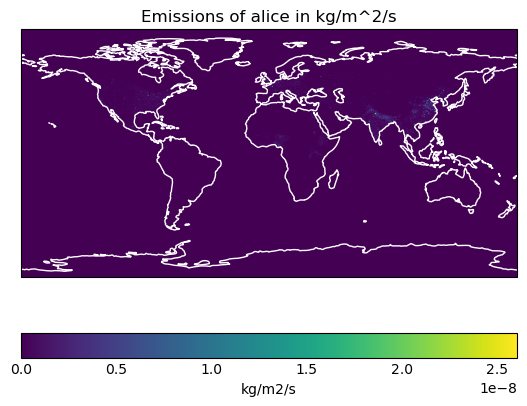

In [4]:
qplt.pcolormesh(nemiss[0,:,:])
plt.gca().coastlines(color='w')

Be sure to use a stencil field that exists in the file - both CO and O3 would be fine here

In [5]:
# read-in a UKCA field from our model output
# take CO as basic shape, although could take O3 as well
indata=iris.load_cube(datafile,iris.AttributeConstraint(STASH='m01s34i010'))
# guess the bounds of the grid file
indata.coord(axis='x').guess_bounds()
indata.coord(axis='y').guess_bounds()

/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/fileformats/rules.py:371: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(


In [6]:
# make sure that we use the same coordinate system, otherwise regrid won't work
nemiss.coord(axis='x').coord_system=indata.coord_system()
nemiss.coord(axis='y').coord_system=indata.coord_system()
# now guess the bounds of the new grid prior to regridding
nemiss.coord(axis='x').guess_bounds()
nemiss.coord(axis='y').guess_bounds()

In [7]:
# now regrid to the supplied O3 grid using area weighted regridding
emiss_regrid=nemiss.regrid(indata,iris.analysis.AreaWeighted())

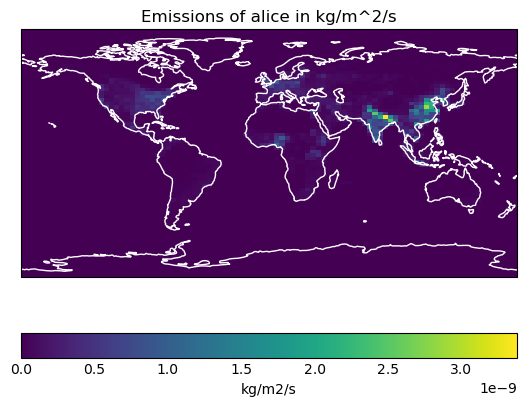

In [8]:
qplt.pcolormesh(emiss_regrid[0,:,:])
plt.gca().coastlines(color='w')

Here we will need to change all the attributes to match ALICE

In [9]:
# now add correct attributes and names to netCDF file
emiss_regrid.var_name='emissions_ALICE'
emiss_regrid.long_name='ALICE surf emissions'
emiss_regrid.units=cf_units.Unit('kg m-2 s-1')
emiss_regrid.attributes['vertical_scaling']='surface'
emiss_regrid.attributes['tracer_name']='ALICE'
# global attributes, so don't set in local_keys
# NOTE: all these should be strings, including the numbers!
# basic emissions type
emiss_regrid.attributes['update_type']='2'   # same as above
emiss_regrid.attributes['update_freq_in_hours']='120' # i.e. 5 days

In [10]:
# time dimension
# rename and set time coord - set to be 0000/01/16:00:00-0000/12/16:00:00
emiss_regrid.coord(axis='t').var_name='time'
emiss_regrid.coord(axis='t').standard_name='time'
emiss_regrid.coords(axis='t')[0].units=cf_units.Unit('hours since 1970-01-01', calendar='360_day')
emiss_regrid.coord(axis='t').points=np.array([-17020440, -17019720, -17019000, -17018280,
                                          -17017560, -17016840, -17016120, -17015400, 
                                          -17014680, -17013960, -17013240, -17012520])

In [11]:
# make z-direction.
zdims=iris.coords.DimCoord(np.array([0]),standard_name = 'model_level_number',
                           units='1',attributes={'positive':'up'})
emiss_regrid.add_aux_coord(zdims)
emiss_regrid=iris.util.new_axis(emiss_regrid, zdims)
# now transpose cube to put Z 2nd
emiss_regrid.transpose([1,0,2,3])

In [12]:
# set _FillValue
fillval=1e+20
emiss_regrid.data = np.ma.array(data=emiss_regrid.data, fill_value=fillval)
# set a missing_value attribute as well as a _FillValue attribute
emiss_regrid.attributes['missing_value']=np.float32(fillval)

In [13]:
# make coordinates 64-bit
emiss_regrid.coord(axis='x').points=emiss_regrid.coord(axis='x').points.astype(dtype='float64')
emiss_regrid.coord(axis='y').points=emiss_regrid.coord(axis='y').points.astype(dtype='float64')
emiss_regrid.coord(axis='t').points=emiss_regrid.coord(axis='t').points.astype(dtype='float64')
emiss_regrid.coord('latitude').bounds=emiss_regrid.coord('latitude').bounds.astype(dtype='float64')

Here we need to change the name of the output file

In [14]:
# now write-out the file
# output file name, based on species
outpath='/home/vagrant/ukca_emiss_ALICE.nc'
# now write-out to netCDF
# may need to set environment variable HDF5_USE_FILE_LOCKING=FALSE for NETCDF4 format to
# prevent a HDF error.
# Use NETCDF4_CLASSIC as NETCDF4 has strange issues with longitude points
saver = iris.fileformats.netcdf.Saver(filename=outpath, netcdf_format='NETCDF4_CLASSIC')
saver.update_global_attributes(Conventions=iris.fileformats.netcdf.CF_CONVENTIONS_VERSION)
saver.write(emiss_regrid, local_keys=['vertical_scaling', 'missing_value','tracer_name', '_FillValue'], fill_value=fillval)
